## Task 2 - Model Building and Training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.model_utils import *

In [4]:
# Load fraud data
fraud_data = pd.read_csv('../data/processed/processed_fraud_data.csv')
# Load credit card data
credit_data = pd.read_csv('../data/processed/processed_credit_card.csv')

In [5]:
fraud_data.head()

,user_id,purchase_value,device_id,age,ip_address,class,ip_int,hour_of_day,day_of_week,month,...,country_Zambia,country_Zimbabwe,signup_hour,signup_day,signup_year,signup_month,purchase_hour,purchase_day,purchase_year,purchase_month
0,247547,0.549607,46780,-0.363124,-1.728724,0,-1.728724,-1.231124,1.487911,0.749993,...,False,False,22,1,2015,2,2,5,2015,4
1,220737,-1.197335,70073,0.101168,-1.728666,0,-1.728666,1.229002,-0.505034,-1.500438,...,False,False,20,6,2015,6,1,0,2015,6
2,390400,0.385831,53448,-0.479197,-1.728664,0,-1.728664,1.663142,0.989675,-0.750295,...,False,False,18,3,2015,1,18,3,2015,1
3,69592,0.986342,92195,-0.363124,-1.728577,0,-1.728577,0.650149,0.989675,-0.375223,...,False,False,21,1,2015,4,13,0,2015,5
4,174987,0.767974,107434,0.449387,-1.728546,0,-1.728546,-1.086411,-1.003270,1.875208,...,False,False,7,1,2015,7,18,2,2015,9


In [6]:
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996823,-0.701082,-0.041687,1.680101,0.976623,-0.247020,0.348012,0.193700,0.084434,0.333534,...,-0.024777,0.383483,-0.177444,0.110157,0.247059,-0.392622,0.333033,-0.065850,0.244200,0
1,-1.996823,0.608792,0.164138,0.109279,0.318998,0.042258,-0.060980,-0.065656,0.072903,-0.231703,...,-0.311372,-0.881454,0.162081,-0.561503,0.321175,0.260854,-0.027154,0.043219,-0.342584,0
2,-1.996802,-0.700336,-0.811337,1.174270,0.270648,-0.366756,1.352655,0.643223,0.210788,-1.381169,...,0.343094,1.065068,1.457772,-1.138484,-0.628161,-0.288861,-0.144325,-0.183824,1.158900,0
3,-1.996802,-0.499064,-0.109972,1.187383,-0.608355,-0.008814,0.937245,0.192079,0.320843,-1.264664,...,-0.149093,0.007299,-0.305465,-1.941446,1.242487,-0.460694,0.154039,0.185687,0.139886,0
4,-1.996781,-0.597606,0.535539,1.025470,0.287092,-0.297036,0.072873,0.481517,-0.228725,0.747917,...,-0.012516,1.101780,-0.220709,0.232904,-0.394800,1.041677,0.550001,0.654234,-0.073813,0


In [7]:
print(fraud_data.isnull().sum())

user_id           0
purchase_value    0
device_id         0
age               0
ip_address        0
                 ..
signup_month      0
purchase_hour     0
purchase_day      0
purchase_year     0
purchase_month    0
Length: 212, dtype: int64


In [8]:
fraud_data.dtypes

user_id             int64
purchase_value    float64
device_id           int64
age               float64
ip_address        float64
                   ...   
signup_month        int64
purchase_hour       int64
purchase_day        int64
purchase_year       int64
purchase_month      int64
Length: 212, dtype: object

In [9]:
fraud_data.columns

Index(['user_id', 'purchase_value', 'device_id', 'age', 'ip_address', 'class',
       'ip_int', 'hour_of_day', 'day_of_week', 'month',
       ...
       'country_Zambia', 'country_Zimbabwe', 'signup_hour', 'signup_day',
       'signup_year', 'signup_month', 'purchase_hour', 'purchase_day',
       'purchase_year', 'purchase_month'],
      dtype='object', length=212)

In [10]:
credit_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
#Initialize MLflow experiment
mlflow.set_experiment("fraud_detection_comparison")

<Experiment: artifact_location='file:///d:/KIFIYA%20AIM/WEEK%208%20and%209/fraud-detection-system/notebooks/mlruns/866612708605881450', creation_time=1738961510101, experiment_id='866612708605881450', last_update_time=1738961510101, lifecycle_stage='active', name='fraud_detection_comparison', tags={}>

In [12]:
# Initialize the modeling class for both datasets
fraud_detector_ecommerce = FraudDetectionModeling(experiment_name="ecommerce_fraud_detection")
fraud_detector_credit = FraudDetectionModeling(experiment_name="credit_fraud_detection")

In [13]:
# Encode Categorical Features
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['device_id','age_group']
le = LabelEncoder()
for col in categorical_columns:
    fraud_data[col] = le.fit_transform(fraud_data[col])

### Prepare features and target for both datasets

In [14]:
# For Fraud Data
X_fraud = fraud_data.drop(['class'], axis=1)
y_fraud = fraud_data['class']

In [15]:
print(X_fraud.dtypes)

user_id             int64
purchase_value    float64
device_id           int64
age               float64
ip_address        float64
                   ...   
signup_month        int64
purchase_hour       int64
purchase_day        int64
purchase_year       int64
purchase_month      int64
Length: 211, dtype: object


In [16]:
X_train_fraud_scaled, X_test_fraud_scaled, y_train_fraud, y_test_fraud = \
    fraud_detector_ecommerce.prepare_data(X_fraud, y_fraud, test_size=0.2, sampling_strategy='balanced')

In [17]:
print("\nPreparing Credit Card Fraud Data...")
X_credit = credit_data.drop(['Class'], axis=1)
y_credit = credit_data['Class']


Preparing Credit Card Fraud Data...


In [18]:
X_train_credit_scaled, X_test_credit_scaled, y_train_credit, y_test_credit = \
    fraud_detector_credit.prepare_data(X_credit, y_credit, test_size=0.2, sampling_strategy='balanced')

### Initialize models for both datasets

In [19]:
# Initialize models for both datasets
print("\nInitializing models...")
# E-commerce fraud models
fraud_detector_ecommerce.initialize_traditional_models()
fraud_detector_ecommerce.initialize_deep_models(input_shape=(X_train_fraud_scaled.shape[1], 1))


Initializing models...


In [20]:
# Credit card fraud models
fraud_detector_credit.initialize_traditional_models()
fraud_detector_credit.initialize_deep_models(input_shape=(X_train_credit_scaled.shape[1], 1))

In [21]:
# Train and evaluate ML models
print("\nTraining traditional models...")

# Machine learning models for E-commerce fraud
traditional_models = ['logistic_regression', 'decision_tree', 'random_forest', 
                     'gradient_boosting', 'mlp']

print("\nTraining E-commerce Fraud Detection Models:")
for model_name in traditional_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_ecommerce.train_traditional_model(model_name)


Training traditional models...

Training E-commerce Fraud Detection Models:

Training logistic_regression...


2025/02/09 16:21:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training decision_tree...


2025/02/09 16:22:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training random_forest...


2025/02/09 16:24:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training gradient_boosting...


2025/02/09 16:30:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training mlp...


2025/02/09 16:34:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
print("\nTraining Credit Card Fraud Detection Models:")
for model_name in traditional_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_credit.train_traditional_model(model_name)


Training Credit Card Fraud Detection Models:

Training logistic_regression...


2025/02/09 16:34:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training decision_tree...


2025/02/09 16:35:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training random_forest...


2025/02/09 16:45:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training gradient_boosting...


2025/02/09 19:37:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training mlp...


2025/02/09 19:40:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Train and evaluate deep learning models

In [23]:
# Train and evaluate deep learning models
print("\nTraining deep learning models...")

# Deep learning models for E-commerce fraud
deep_models = ['cnn', 'rnn', 'lstm']

print("\nTraining E-commerce Fraud Deep Learning Models:")
for model_name in deep_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_ecommerce.train_deep_model(model_name, epochs=10, batch_size=32)

print("\nTraining Credit Card Fraud Deep Learning Models:")
for model_name in deep_models:
    print(f"\nTraining {model_name}...")
    fraud_detector_credit.train_deep_model(model_name, epochs=10, batch_size=32)


Training deep learning models...

Training E-commerce Fraud Deep Learning Models:

Training cnn...
Epoch 1/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 97s 11ms/step - accuracy: 0.7883 - loss: 0.4389 - val_accuracy: 0.9284 - val_loss: 0.2955
Epoch 2/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.8625 - loss: 0.3223 - val_accuracy: 0.8955 - val_loss: 0.3496
Epoch 3/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.8751 - loss: 0.2998 - val_accuracy: 0.8249 - val_loss: 0.4312
Epoch 4/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.8841 - loss: 0.2848 - val_accuracy: 0.8365 - val_loss: 0.4073
Epoch 5/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - accuracy: 0.8911 - loss: 0.2691 - val_accuracy: 0.9024 - val_loss: 0.3357
Epoch 6/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 65s 11ms/step - accuracy: 0.8980 - loss: 0.2569 - val_accuracy: 0.9237 - val_loss: 0.2818
Epoch 7/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 63s 11ms/step - accuracy: 0.9035 - loss: 0.2464 - val_accuracy: 0.

2025/02/09 19:52:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/09 19:54:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\25191\AppData\Local\Temp\tmpsznq69e6\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/09 19:54:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training rnn...
Epoch 1/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 734s 123ms/step - accuracy: 0.5323 - loss: 0.6915 - val_accuracy: 0.1578 - val_loss: 0.7384
Epoch 2/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 655s 108ms/step - accuracy: 0.5282 - loss: 0.6901 - val_accuracy: 0.6369 - val_loss: 0.6790
Epoch 3/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 704s 112ms/step - accuracy: 0.5061 - loss: 0.6934 - val_accuracy: 0.5313 - val_loss: 0.6530
Epoch 4/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 707s 121ms/step - accuracy: 0.5217 - loss: 0.6932 - val_accuracy: 0.2531 - val_loss: 0.7142
Epoch 5/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 917s 157ms/step - accuracy: 0.5119 - loss: 0.6923 - val_accuracy: 0.4998 - val_loss: 0.6765
Epoch 6/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 650s 111ms/step - accuracy: 0.5387 - loss: 0.6893 - val_accuracy: 0.3234 - val_loss: 0.7242
Epoch 7/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 442s 76ms/step - accuracy: 0.5465 - loss: 0.6874 - val_accuracy: 0.4512 - val_loss: 0.6919
Epoch 8/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 417s

2025/02/09 21:36:35 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/09 21:38:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training lstm...
Epoch 1/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 1255s 212ms/step - accuracy: 0.5875 - loss: 0.6677 - val_accuracy: 0.5496 - val_loss: 0.6886
Epoch 2/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 866s 138ms/step - accuracy: 0.6240 - loss: 0.6517 - val_accuracy: 0.5476 - val_loss: 0.6969
Epoch 3/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 1206s 206ms/step - accuracy: 0.6495 - loss: 0.6362 - val_accuracy: 0.6418 - val_loss: 0.6245
Epoch 4/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 1535s 263ms/step - accuracy: 0.6740 - loss: 0.5960 - val_accuracy: 0.7073 - val_loss: 0.5900
Epoch 5/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 775s 132ms/step - accuracy: 0.7127 - loss: 0.5393 - val_accuracy: 0.7486 - val_loss: 0.5464
Epoch 6/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 779s 133ms/step - accuracy: 0.7594 - loss: 0.4788 - val_accuracy: 0.8259 - val_loss: 0.4592
Epoch 7/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 26975s 5s/step - accuracy: 0.7932 - loss: 0.4307 - val_accuracy: 0.8166 - val_loss: 0.4830
Epoch 8/10
5844/5844 ━━━━━━━━━━━━━━━━━━━━ 

2025/02/10 07:48:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 07:50:41 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\25191\AppData\Local\Temp\tmpm3ygcd8v\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/10 07:50:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training Credit Card Fraud Deep Learning Models:

Training cnn...
Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 170s 10ms/step - accuracy: 0.9816 - loss: 0.0504 - val_accuracy: 0.9958 - val_loss: 0.0200
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.9974 - val_loss: 0.0178
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.9989 - loss: 0.0045 - val_accuracy: 0.9982 - val_loss: 0.0171
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 141s 10ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.9988 - val_loss: 0.0184
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 143s 10ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9980 - val_loss: 0.0234
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 142s 10ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9990 - val_loss: 0.0232
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 146s 10ms/step - accuracy: 0.9995 - loss: 0.0021 - val_accuracy: 0.9992 - val_l

2025/02/10 08:14:49 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 08:15:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training rnn...
Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 221s 15ms/step - accuracy: 0.9760 - loss: 0.0611 - val_accuracy: 0.9901 - val_loss: 0.0288
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 228s 16ms/step - accuracy: 0.9939 - loss: 0.0194 - val_accuracy: 0.9904 - val_loss: 0.0305
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 227s 16ms/step - accuracy: 0.9946 - loss: 0.0178 - val_accuracy: 0.9943 - val_loss: 0.0188
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 228s 16ms/step - accuracy: 0.9945 - loss: 0.0183 - val_accuracy: 0.9917 - val_loss: 0.0241
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 227s 16ms/step - accuracy: 0.9936 - loss: 0.0208 - val_accuracy: 0.9953 - val_loss: 0.0159
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 229s 16ms/step - accuracy: 0.9924 - loss: 0.0243 - val_accuracy: 0.9891 - val_loss: 0.0331
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 228s 16ms/step - accuracy: 0.9929 - loss: 0.0234 - val_accuracy: 0.9935 - val_loss: 0.0213
Epoch 8/10
14163/14163 ━━━━━━━━━━━━━━━

2025/02/10 09:03:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 09:05:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\25191\AppData\Local\Temp\tmpvqjg3bqn\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/10 09:05:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Training lstm...
Epoch 1/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 460s 27ms/step - accuracy: 0.9552 - loss: 0.1173 - val_accuracy: 0.9936 - val_loss: 0.0191
Epoch 2/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 581s 37ms/step - accuracy: 0.9948 - loss: 0.0168 - val_accuracy: 0.9936 - val_loss: 0.0208
Epoch 3/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 511s 36ms/step - accuracy: 0.9974 - loss: 0.0096 - val_accuracy: 0.9977 - val_loss: 0.0096
Epoch 4/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 515s 33ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.9987 - val_loss: 0.0062
Epoch 5/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 393s 28ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9983 - val_loss: 0.0076
Epoch 6/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 560s 40ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9979 - val_loss: 0.0089
Epoch 7/10
14163/14163 ━━━━━━━━━━━━━━━━━━━━ 343s 24ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9971 - val_loss: 0.0135
Epoch 8/10
14163/14163 ━━━━━━━━━━━━━━

2025/02/10 10:22:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/02/10 10:24:15 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\25191\AppData\Local\Temp\tmpf19kf09y\model, flavor: keras). Fall back to return ['keras==3.8.0']. Set logging level to DEBUG to see the full traceback. 
2025/02/10 10:24:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Plot results and compare models

#### results for fraud_data models


E-commerce Fraud Detection Results:


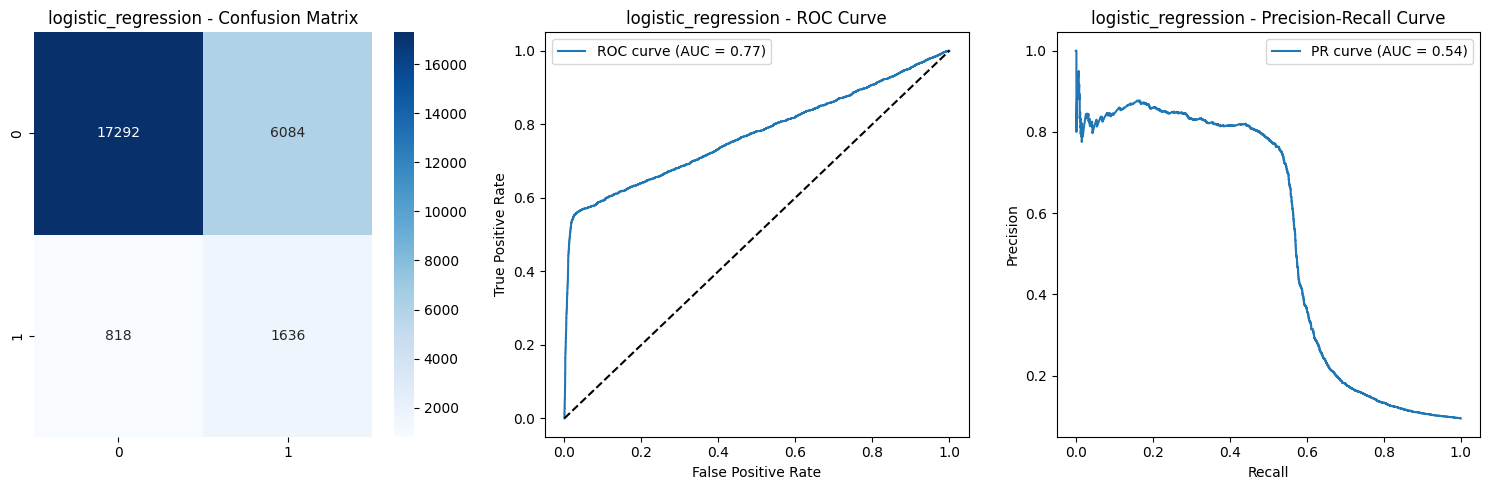

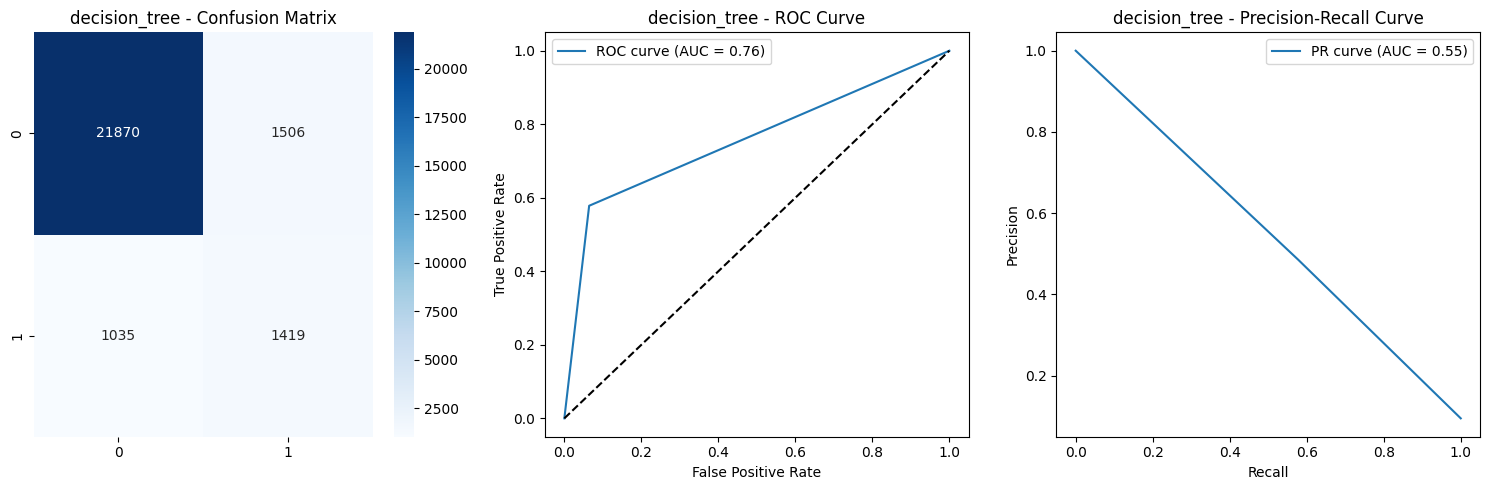

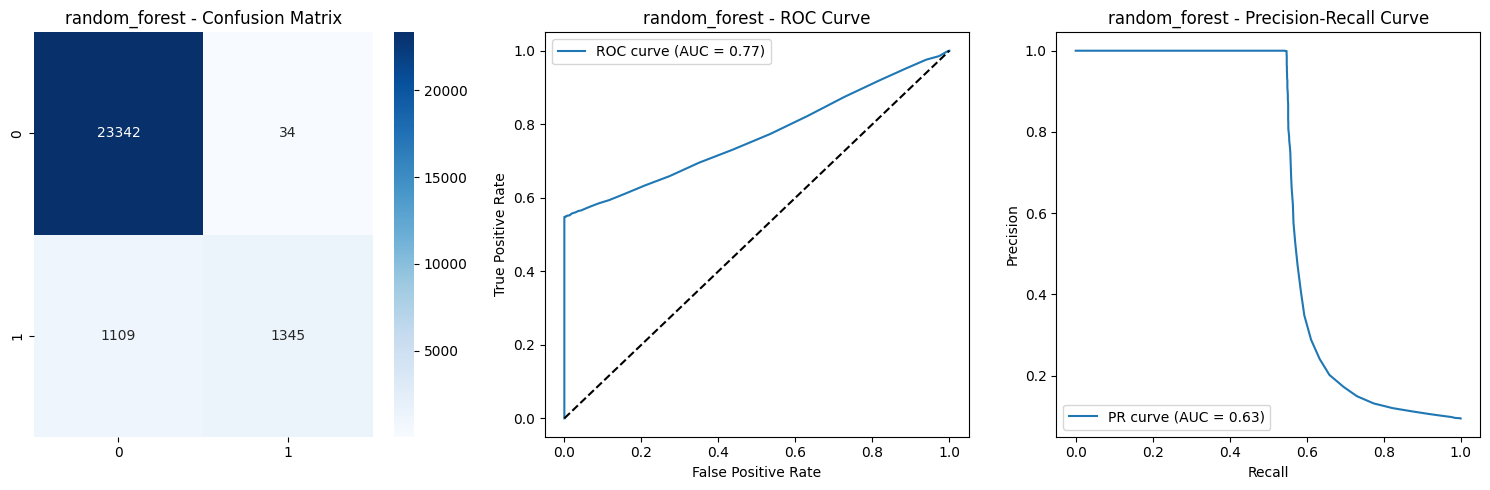

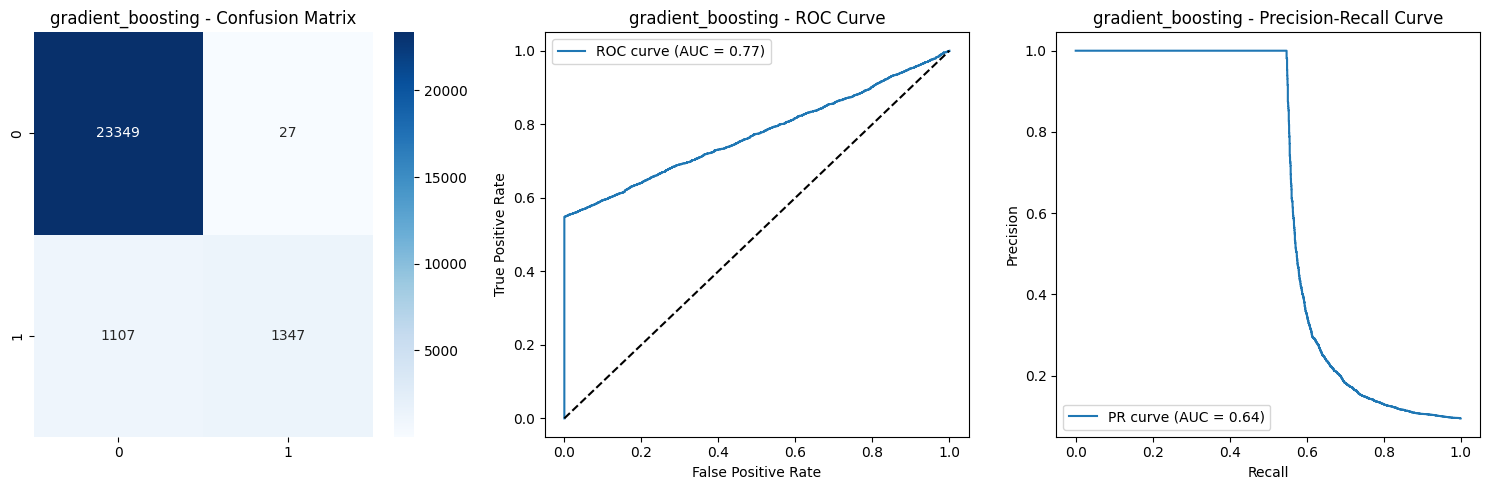

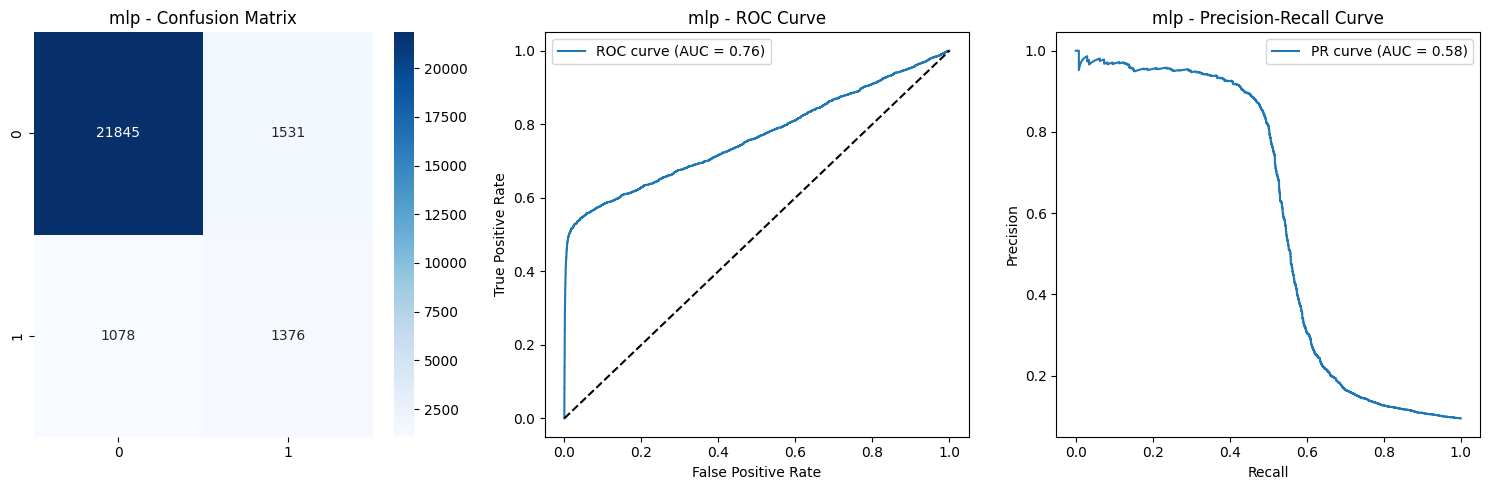

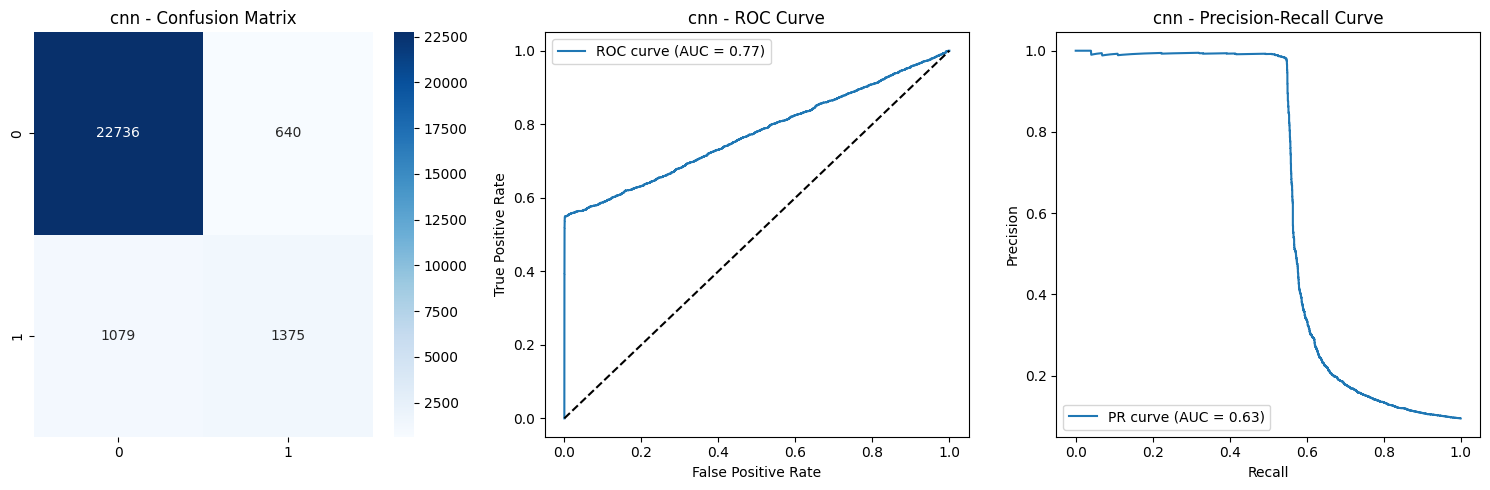

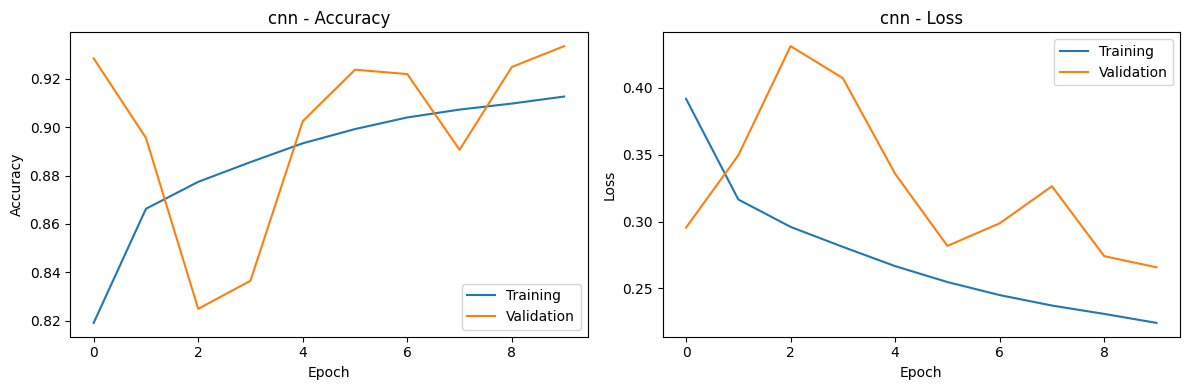

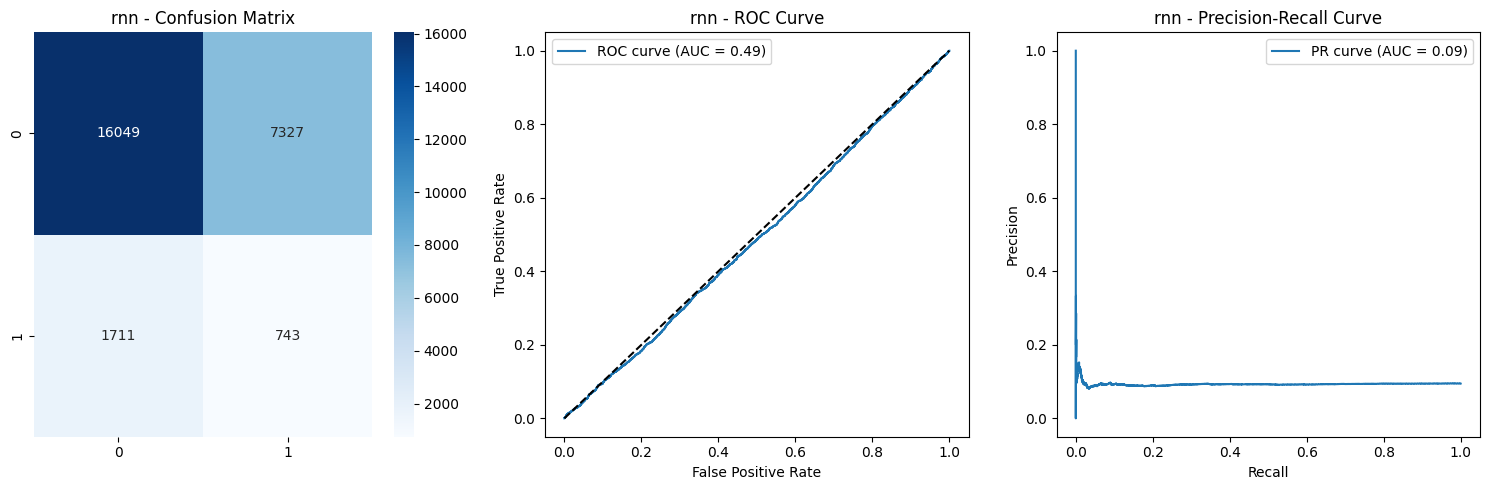

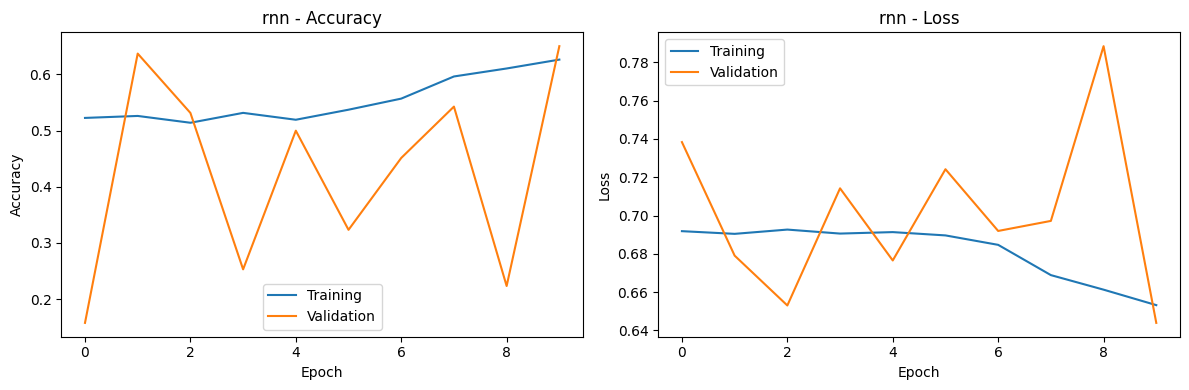

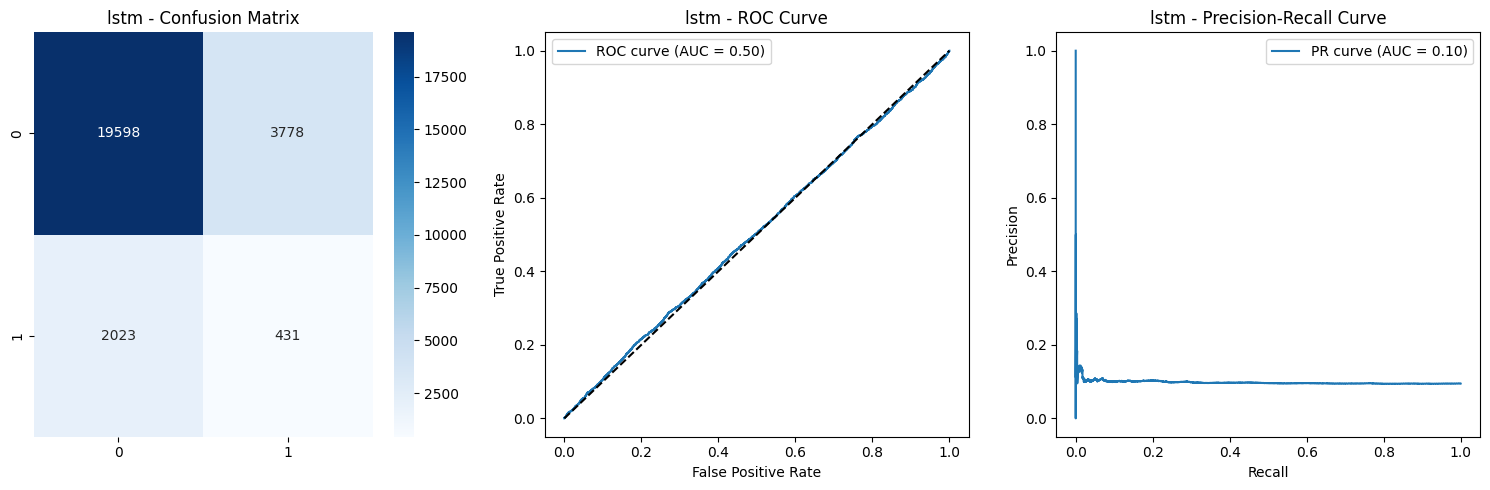

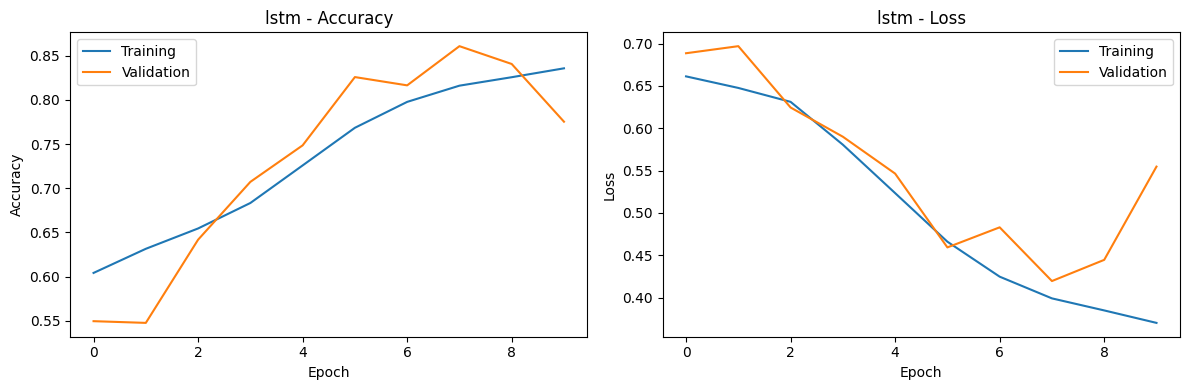

In [24]:
# Plot results for fraud_data models
print("\nE-commerce Fraud Detection Results:")
fraud_detector_ecommerce.plot_results()

### results for credit card fraud models 


Credit Card Fraud Detection Results:


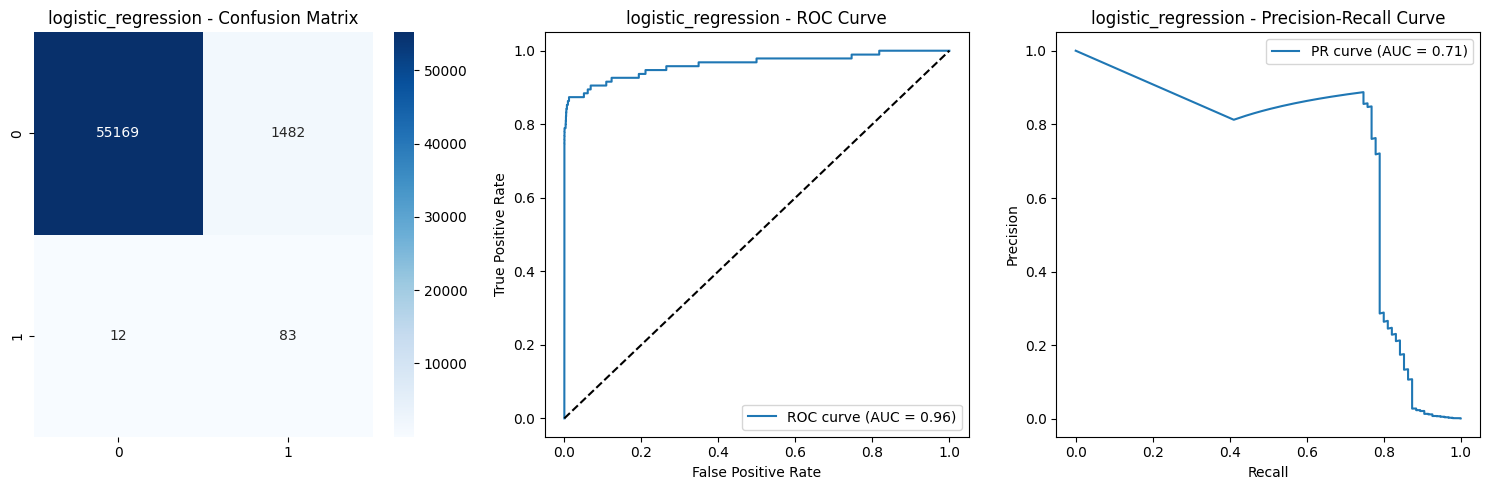

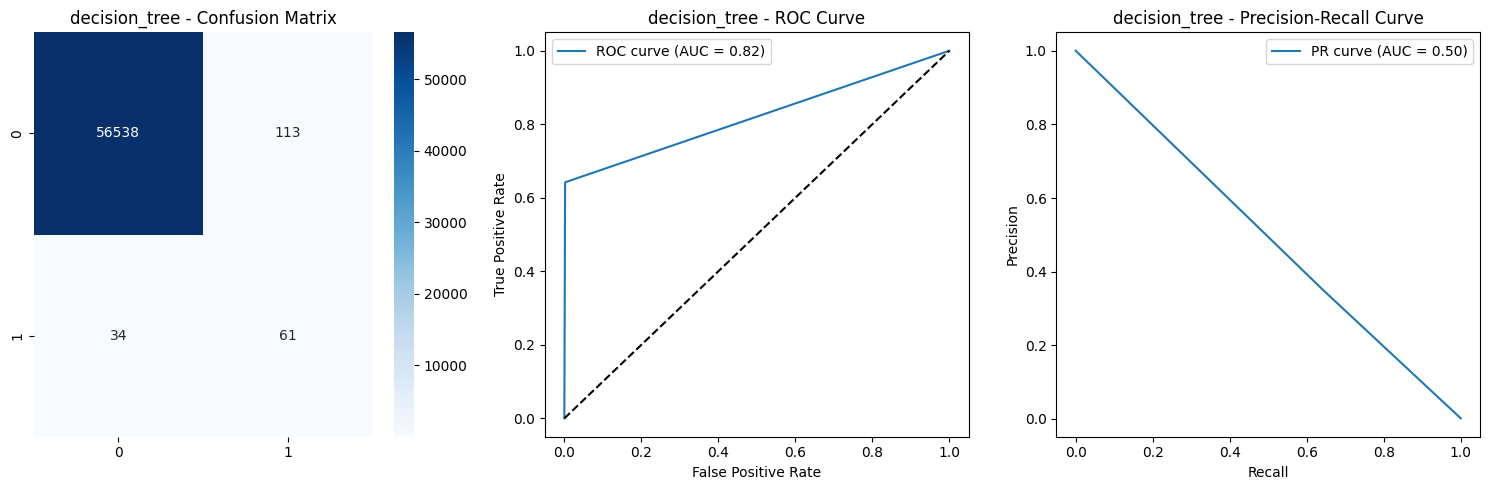

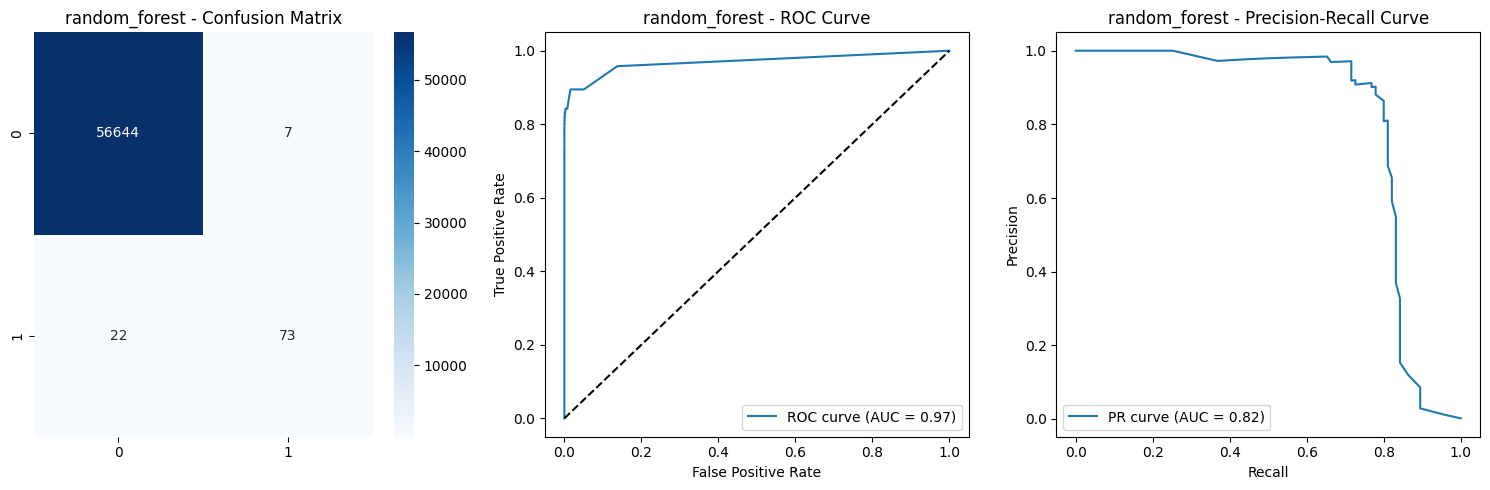

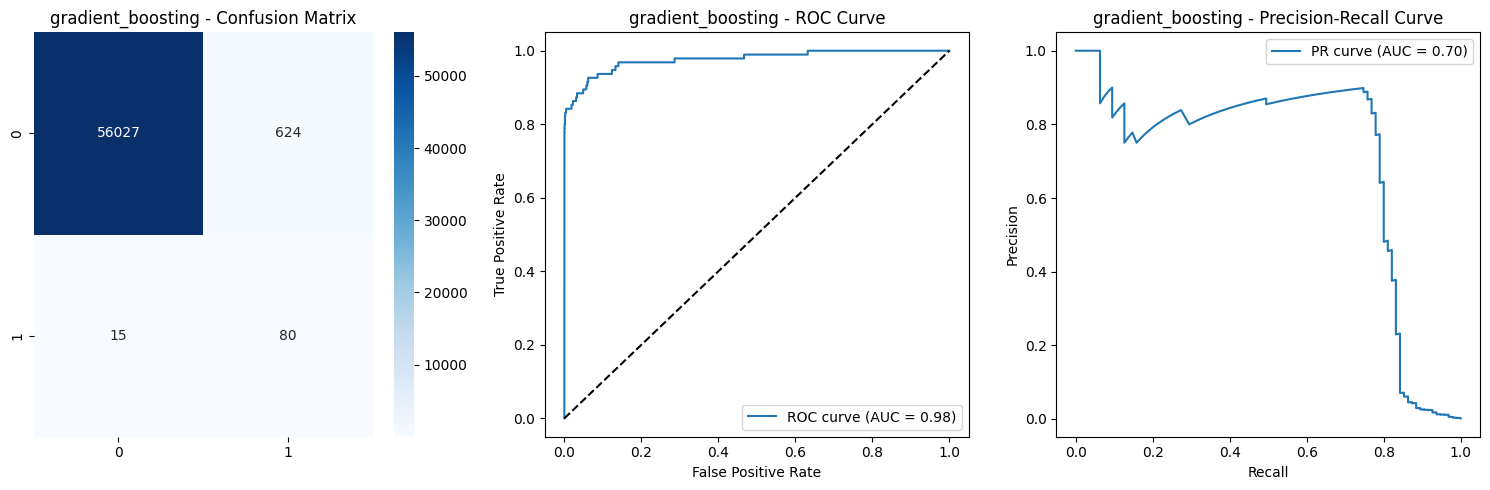

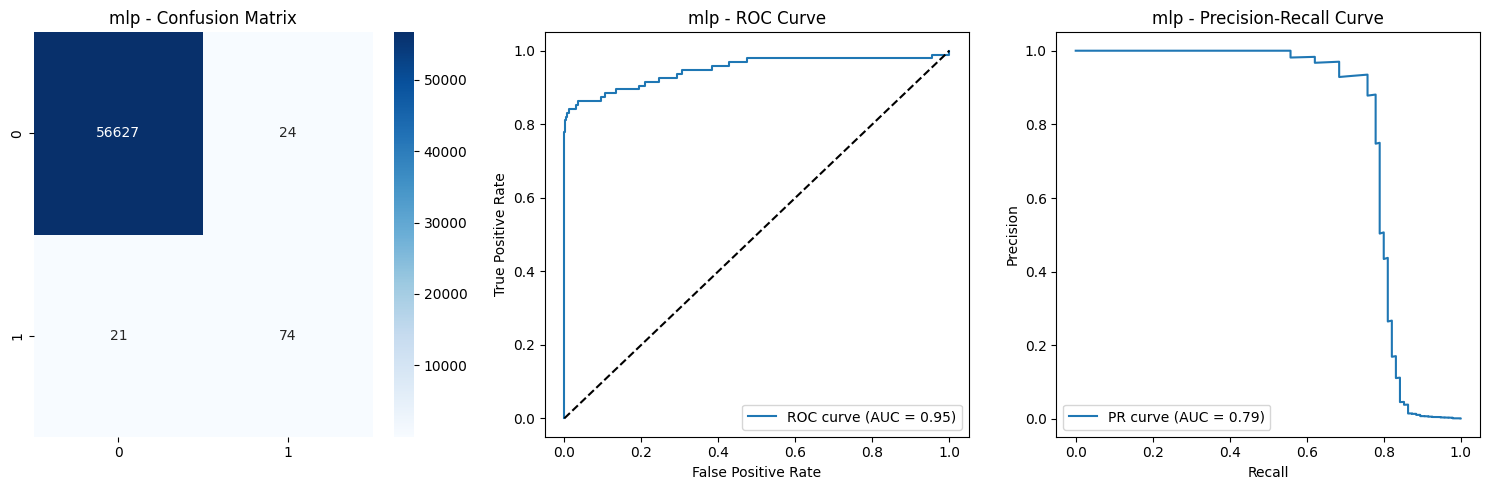

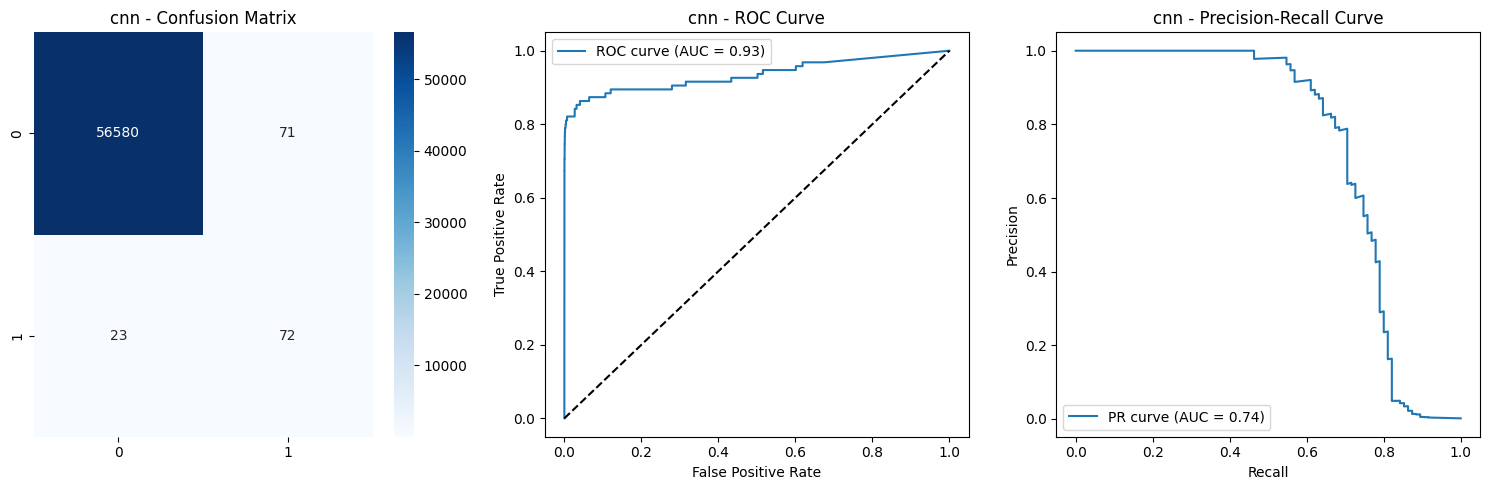

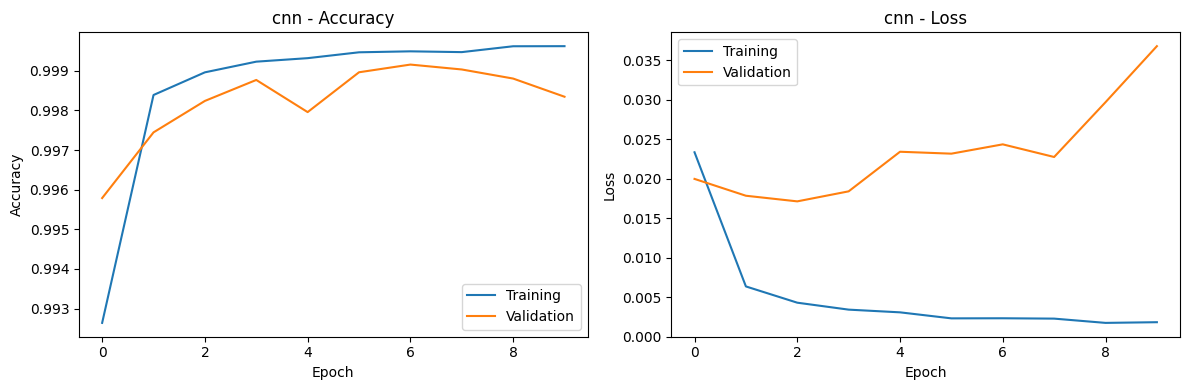

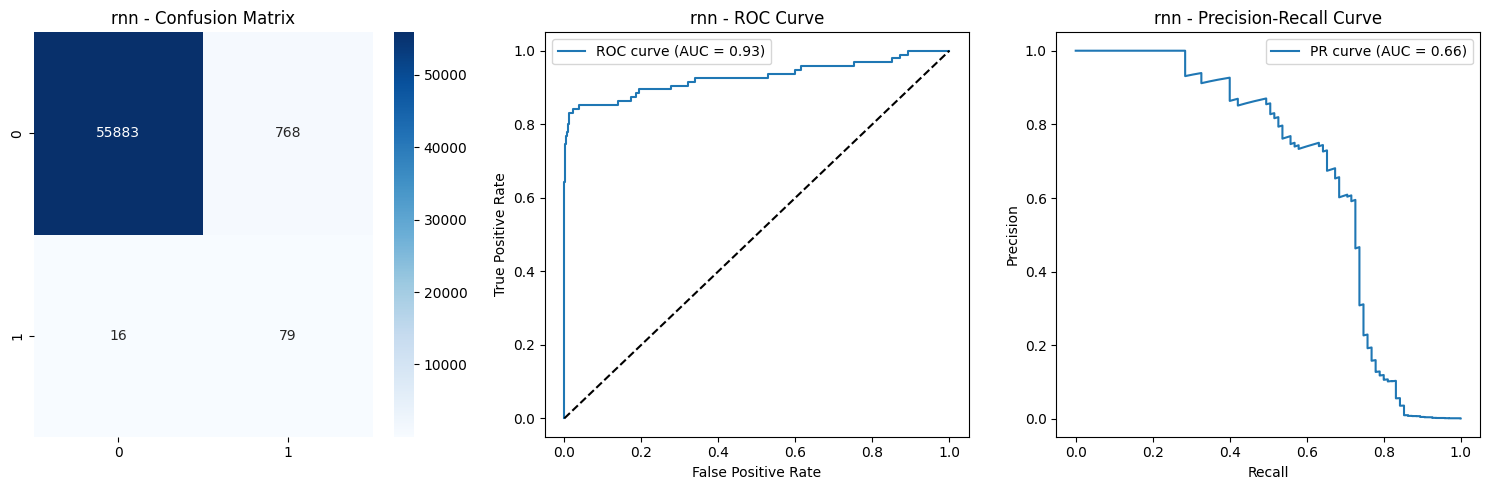

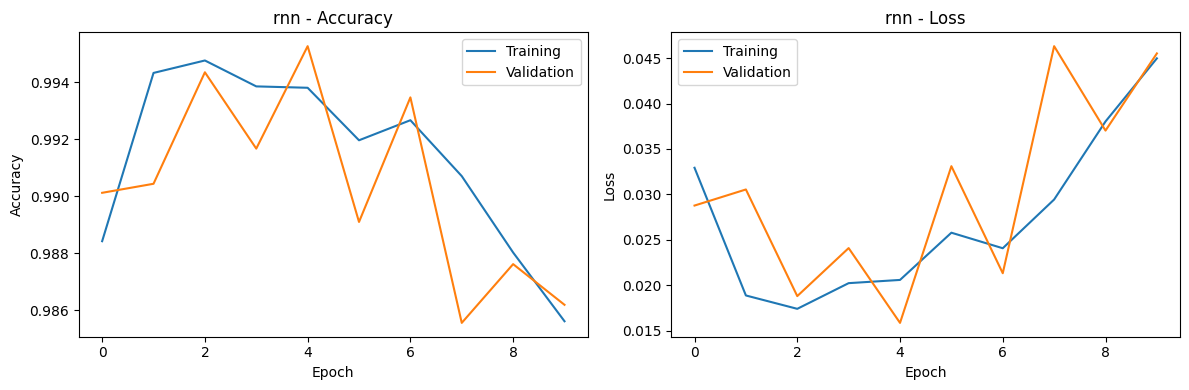

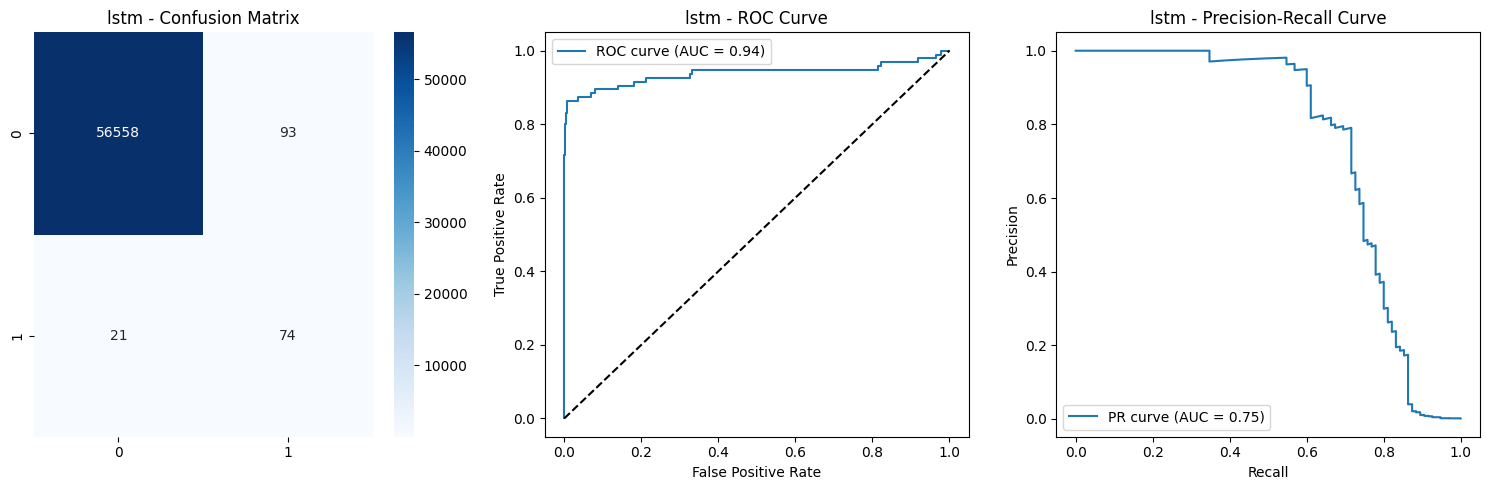

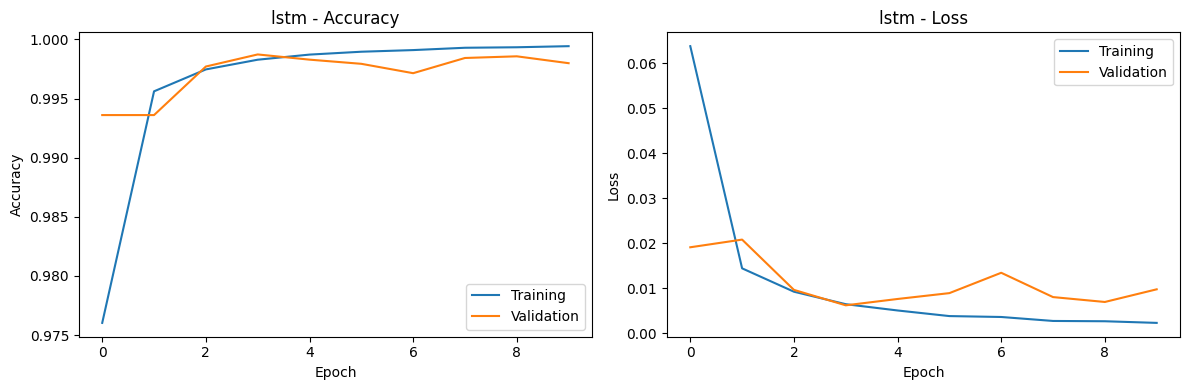

In [25]:
# Plot results for credit card fraud models
print("\nCredit Card Fraud Detection Results:")
fraud_detector_credit.plot_results()

## Compare model performances

In [26]:
# Compare model performances
def print_model_comparison(detector, dataset_name):
    print(f"\nModel Performance Comparison for {dataset_name}:")
    print("-" * 80)
    print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC-ROC':<10}")
    print("-" * 80)
    
    for model_name, results in detector.results.items():
        if 'classification_report' in results:
            metrics = results['classification_report']
            auc_roc = results['roc_curve'][2]
            print(f"{model_name:<20} "
                  f"{metrics['accuracy']:<10.3f} "
                  f"{metrics['weighted avg']['precision']:<10.3f} "
                  f"{metrics['weighted avg']['recall']:<10.3f} "
                  f"{metrics['weighted avg']['f1-score']:<10.3f} "
                  f"{auc_roc:<10.3f}")

print("\nComparing model performances...")
print_model_comparison(fraud_detector_ecommerce, "E-commerce Fraud Detection")
print_model_comparison(fraud_detector_credit, "Credit Card Fraud Detection")


Comparing model performances...

Model Performance Comparison for E-commerce Fraud Detection:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1-Score   AUC-ROC   
--------------------------------------------------------------------------------
logistic_regression  0.733      0.884      0.733      0.785      0.771     
decision_tree        0.902      0.910      0.902      0.905      0.757     
random_forest        0.956      0.957      0.956      0.950      0.767     
gradient_boosting    0.956      0.957      0.956      0.950      0.773     
mlp                  0.899      0.907      0.899      0.903      0.765     
cnn                  0.933      0.929      0.933      0.930      0.774     
rnn                  0.650      0.827      0.650      0.720      0.490     
lstm                 0.775      0.830      0.775      0.801      0.503     

Model Performance Comparison for Credit Card Fraud Detecti

In [27]:
# Save best models
print("\nSaving best models...")

def get_best_model(detector):
    best_f1 = 0
    best_model_name = None
    
    for model_name, results in detector.results.items():
        if 'classification_report' in results:
            f1 = results['classification_report']['weighted avg']['f1-score']
            if f1 > best_f1:
                best_f1 = f1
                best_model_name = model_name
    
    return best_model_name, detector.models[best_model_name]


Saving best models...


In [28]:
# save best models
with mlflow.start_run(run_name="best_models"):
    # Save best e-commerce fraud model
    best_ecommerce_model_name, best_ecommerce_model = get_best_model(fraud_detector_ecommerce)
    mlflow.sklearn.log_model(best_ecommerce_model, "best_ecommerce_fraud_model")
    print(f"\nBest model for E-commerce Fraud Detection: {best_ecommerce_model_name}")
    
    # Save best credit card fraud model
    best_credit_model_name, best_credit_model = get_best_model(fraud_detector_credit)
    mlflow.sklearn.log_model(best_credit_model, "best_credit_fraud_model")
    print(f"Best model for Credit Card Fraud Detection: {best_credit_model_name}")

print("\nModel training and evaluation completed!")

2025/02/10 10:28:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best model for E-commerce Fraud Detection: gradient_boosting


2025/02/10 10:28:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best model for Credit Card Fraud Detection: random_forest

Model training and evaluation completed!


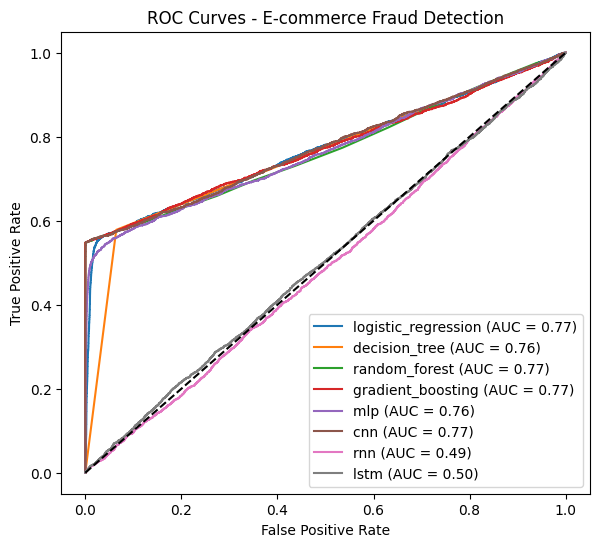

In [29]:
# Generate summary visualizations
plt.figure(figsize=(15, 6))

# ROC curves for all models (E-commerce)
plt.subplot(1, 2, 1)
for model_name, results in fraud_detector_ecommerce.results.items():
    if 'roc_curve' in results:
        fpr, tpr, auc_score = results['roc_curve']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - E-commerce Fraud Detection')
plt.legend()

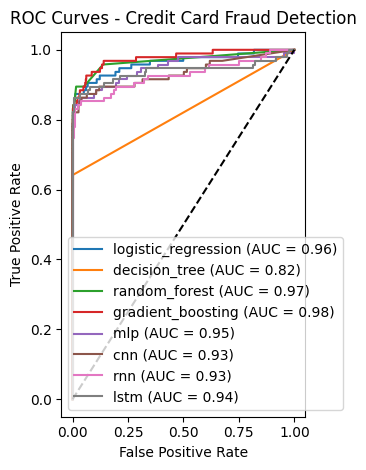

In [30]:
# ROC curves for all models (Credit Card)
plt.subplot(1, 2, 2)
for model_name, results in fraud_detector_credit.results.items():
    if 'roc_curve' in results:
        fpr, tpr, auc_score = results['roc_curve']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Credit Card Fraud Detection')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
# Save the models and scalers for later use
import joblib

# Save the best models and their corresponding scalers
joblib.dump(best_ecommerce_model, 'best_ecommerce_fraud_model.joblib')
joblib.dump(best_credit_model, 'best_credit_fraud_model.joblib')
joblib.dump(fraud_detector_ecommerce.scaler, 'ecommerce_scaler.joblib')
joblib.dump(fraud_detector_credit.scaler, 'credit_scaler.joblib')

print("\nBest models and scalers have been saved to disk!")


Best models and scalers have been saved to disk!


In [32]:
import shap

def explain_model_shap(best_credit_model, X_train, X_test):
    explainer = shap.TreeExplainer(best_credit_model)  # For tree-based models
    shap_values = explainer.shap_values(X_test)
    return shap_values

def shap_summary_plot(best_credit_model, X_train, X_test, feature_names):
    shap_values = explain_model_shap(best_credit_model, X_train, X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

def shap_dependence_plot(best_credit_model, X_train, X_test, feature, feature_names):
    shap_values = explain_model_shap(best_credit_model, X_train, X_test)
    shap.dependence_plot(feature, shap_values, X_test, feature_names=feature_names)


In [35]:
X_train_fraud_scaled, X_test_fraud_scaled, y_train_fraud, y_test_fraud = \
    fraud_detector_ecommerce.prepare_data(X_fraud, y_fraud, test_size=0.2, sampling_strategy='balanced')

In [ ]:
# Call after training the model
shap_summary_plot(best_credit_model, X_fraud, X_test_fraud_scaled, feature_names=fraud_data.columns)

# To visualize the impact of a specific feature
shap_dependence_plot(best_credit_model,X_fraud, X_test_fraud_scaled, 'purchase_value', feature_names=fraud_data.columns)
